# Similarity of representations of different runs of AVA in sample dataset

## Import modules

In [1]:
import h5py
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import random

/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/uma

In [2]:
from ava.data.data_container import DataContainer
from ava.plotting.grid_plot import indexed_grid_plot_DC
import audio_utils.io

In [3]:
%matplotlib inline

## Create data container objects

In [4]:
root = '/mnt/labNAS/usv_calls/usv_note_analysis'
runs = ['230118_MZ18_MZ23_1_run1_long','230118_MZ18_MZ23_1_run2','230118_MZ18_MZ23_1_run3','230118_MZ18_MZ23_1_run4','230118_MZ18_MZ23_1_run5_long']
models = ['checkpoint_030.tar','checkpoint_010.tar','checkpoint_010.tar','checkpoint_010.tar','checkpoint_030.tar']
projection_dirs = [os.path.join(root, run, 'projections_sampl') for run in runs]
spec_dirs = [os.path.join(root, runs[0], 'specs_sampl')]
model_filenames = [os.path.join(root, run, model) for run, model in zip(runs, models)]
plot_dirs = [os.path.join(root, run) for run in runs]
dcs = [DataContainer(projection_dirs=[projection_dir], spec_dirs=spec_dirs, model_filename=model_filename, plots_dir=plots_dir)
       for projection_dir, model_filename, plots_dir in zip(projection_dirs, model_filenames, plot_dirs)]

In [5]:
onsets = dcs[0].request('onsets')
offsets = dcs[0].request('offsets')
ava_embedding_detections = pd.DataFrame(np.vstack([onsets, offsets]).T, columns=['onsets', 'offsets'])
#ava_embedding_detections = ava_embedding_detections.sort_values('onsets',ascending=True)
ava_embedding_detections

Reading field: onsets
	Done with: onsets
Reading field: offsets
	Done with: offsets


,onsets,offsets
0,54.5965,54.6880
1,64.0520,64.1205
2,74.4073,74.4868
3,96.4457,96.5391
4,427.3171,427.4666
...,...,...
995,1265.9061,1266.0001
996,1273.3412,1273.4137
997,1282.6616,1282.7616
998,1304.2625,1304.3575


## Embed latent means

In [6]:
latent_means = [dc.request('latent_means') for dc in dcs]

Reading field: latent_means
	Done with: latent_means
Reading field: latent_means
	Done with: latent_means
Reading field: latent_means
	Done with: latent_means
Reading field: latent_means
	Done with: latent_means
Reading field: latent_means
	Done with: latent_means


## Perform hierarchical clustering

In [7]:
#distance_matrix = euclidean_distances(latent_means)
#similarity_matrix = 1/(1+distance_matrix)
similarity_vectors = []
similarity_matrix = cosine_similarity(latent_means[0])
linkage_matrix = linkage(similarity_matrix, method='complete')

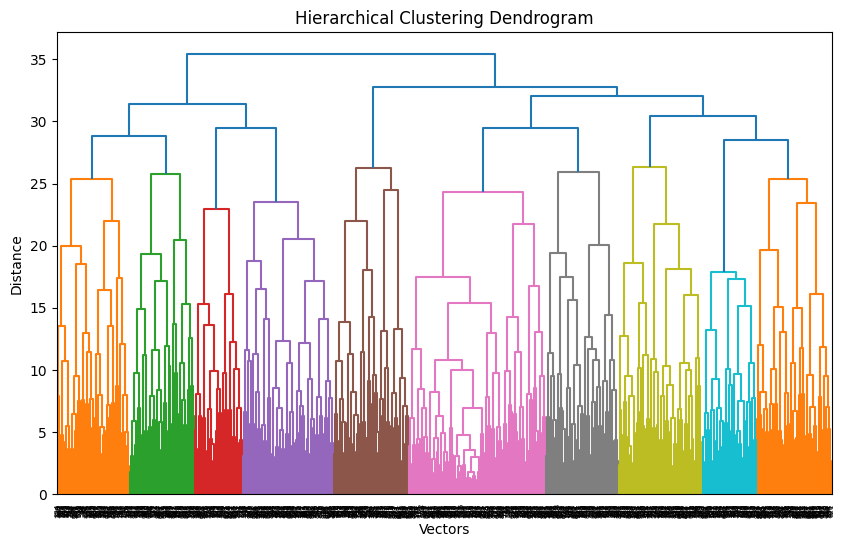

In [15]:
threshold = 27
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix,color_threshold=threshold)
plt.xlabel('Vectors')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

## Assess representation similarity across runs

Text(0.5, 1.0, 'Run 1')

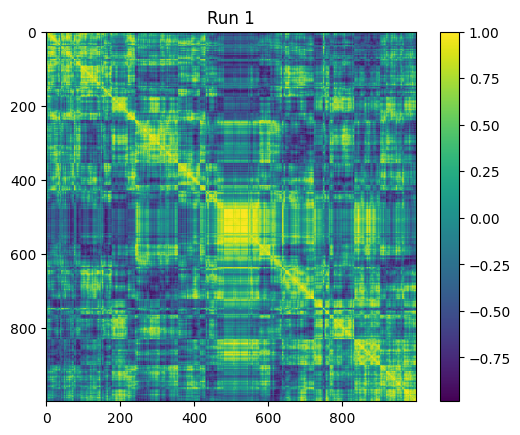

In [14]:
# Get the order of samples in the clustered tree
leaves_list = dendrogram(linkage_matrix, no_plot=True)['leaves']

# Reorder the similarity matrix based on the clustering
reordered_matrix = similarity_matrix[leaves_list][:, leaves_list]
similarity_vectors.append(reordered_matrix.flatten())

plt.imshow(reordered_matrix)
plt.colorbar()
plt.title('Run 1')

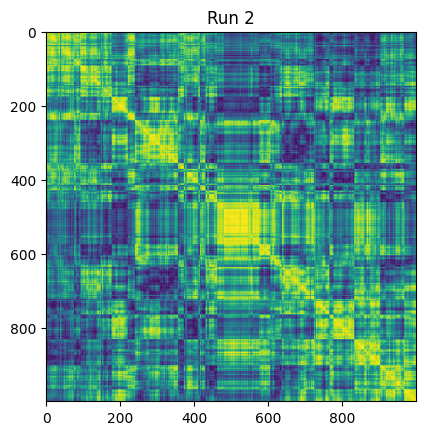

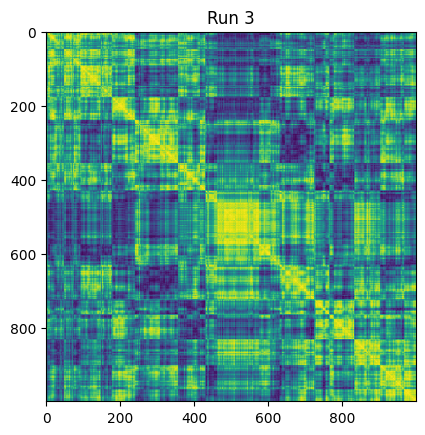

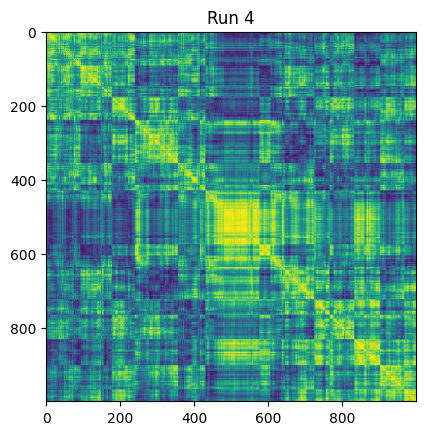

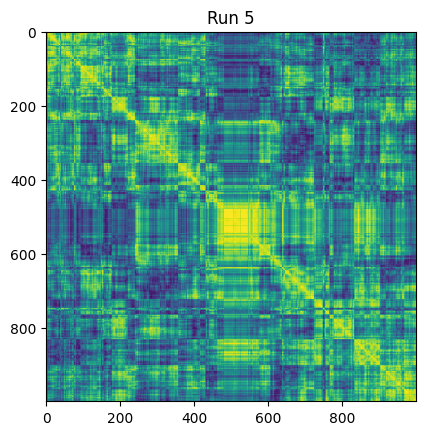

In [10]:
for i in range(len(dcs)-1):
    #distance_matrix1 = euclidean_distances(latent_means1)
    #similarity_matrix1 = 1/(1+distance_matrix1)
    similarity_matrix = cosine_similarity(latent_means[i+1])
    reordered_matrix = similarity_matrix[leaves_list][:, leaves_list]
    similarity_vectors.append(reordered_matrix.flatten())

    plt.imshow(reordered_matrix)
    plt.title('Run {}'.format(int(i+2)))
    plt.show()

In [11]:
correlation_matrix = np.corrcoef(similarity_vectors)
print(np.round(correlation_matrix,3))

[[1.    0.727 0.803 0.809 0.747]
 [0.727 1.    0.838 0.787 0.839]
 [0.803 0.838 1.    0.832 0.804]
 [0.809 0.787 0.832 1.    0.774]
 [0.747 0.839 0.804 0.774 1.   ]]


## Dimensionality of latents

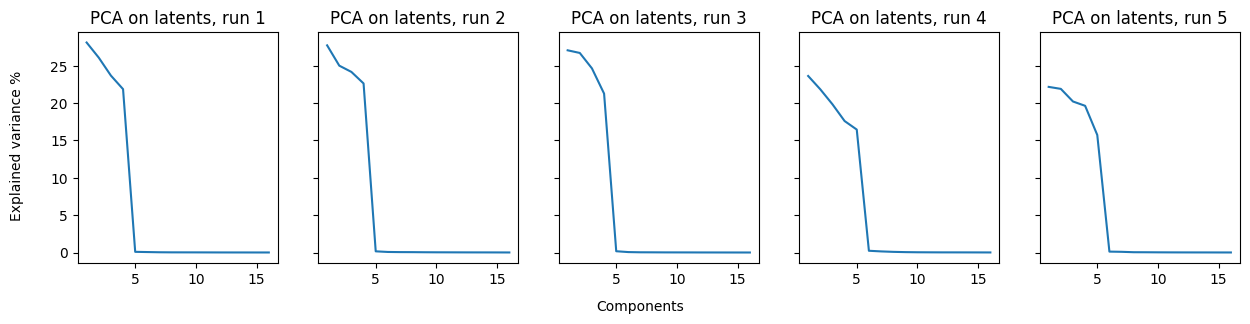

In [42]:
n_comp = 32
show = n_comp//2

# Create a figure and five subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)

# Plot the data on each subplot
for i, ax in enumerate(axes):
    
    # Fit PCA
    pca = PCA(n_components=n_comp)
    pca.fit(latent_means[i])
    
    # Access the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    
    ax.plot(np.arange(1,show+1),100*explained_variance_ratio[:show])
    ax.set_title(f"PCA on latents, run {i+1}")

# Set common x and y labels
fig.text(0.5, -0.05, 'Components', ha='center')
fig.text(0.08, 0.5, 'Explained variance %', va='center', rotation='vertical')

# Display the plot
plt.show()

## Plot several examples from each class

In [46]:
# Assign cluster labels based on the threshold
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Create a dictionary to store an index from each assigned class
class_indexes = {}

# Iterate over the cluster labels and store the indexes for each class
for i, cluster_label in enumerate(clusters):
    if cluster_label not in class_indexes:
        class_indexes[cluster_label] = []
    class_indexes[cluster_label].append(i)

# Retrieve the unique class labels in the order they appear in the dendrogram
unique_labels = np.unique(clusters)

In [14]:
np.random.seed(13)

# Set the number of random examples to select from each class
num_examples = 5

# Randomly select examples from each class
random_indexes = {}
for label, indexes in class_indexes.items():
    random_indexes[label] = np.random.choice(indexes, size=num_examples, replace=False)

In [15]:
indices = random_indexes.values()
indexed_grid_plot_DC(dcs[0], np.array(list(random_indexes.values())).T)

Reading field: specs
	Done with: specs
